In [118]:
import os
import numpy as np
import librosa
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight


def load_data(dataset_path):
    X, y = [], []

    class_names = [f for f in os.listdir(dataset_path) if not f.startswith('.')]
    class_names.sort()

    for class_label, class_dir in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_dir)
        if os.path.isdir(class_path):
            for wav_file in os.listdir(class_path):
                if wav_file.endswith('.wav'):
                    wav_path = os.path.join(class_path, wav_file)
                    wav, sr = librosa.load(wav_path, sr=16000)
                    # wav = augment(samples=wav, sample_rate=sr)  # Comment out or remove this line
                    X.append(wav)
                    y.append(class_label)

    return np.array(X, dtype=object), np.array(y), class_names






In [126]:

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

def extract_features(model, X):
    features = []
    for wav in X:
        scores, embeddings, spectrogram = model(wav)
        features.append(embeddings.numpy().mean(axis=0))
    return np.array(features)

# Load data and extract features
X, y, class_names = load_data('/Users/ankush/Downloads/deakin-units/data/cleaned3')  # Replace with your dataset path
X_features = extract_features(yamnet_model, X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)


# Encode labels to integers
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


2023-09-11 00:42:40.666823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [135]:


# Calculate class weights
unique_classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights_dict = dict(enumerate(class_weights))




# Build and train a new model
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_features.shape[1],)),
   
    layers.Dense(64, activation='relu'),
    
    
    layers.Dense(len(class_names), activation='softmax'), # Use class_names to determine the number of outputs
])




model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Training the model
history = model.fit(X_train, y_train, 
                    epochs=150, 
                    batch_size=64, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=class_weights_dict)  # Adding class weights here

# Evaluate the model on the test set

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 64)                65600     
                                                                 
 dense_76 (Dense)            (None, 64)                4160      
                                                                 
 dense_77 (Dense)            (None, 14)                910       
                                                                 
Total params: 70670 (276.05 KB)
Trainable params: 70670 (276.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/150


2023-09-11 00:47:42.459114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-11 00:47:42.500135: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


33/33 [==============================] - 1s 23ms/step - loss: 2.2684 - accuracy: 0.3212 - val_loss: 1.7724 - val_accuracy: 0.4584
Epoch 2/150


2023-09-11 00:47:43.328200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/ankush/anaconda3/envs/new_env/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 0s 11ms/step - loss: 1.6589 - accuracy: 0.5010 - val_loss: 1.4246 - val_accuracy: 0.5899
Epoch 3/150
33/33 [==============================] - 0s 10ms/step - loss: 1.3728 - accuracy: 0.6226 - val_loss: 1.2275 - val_accuracy: 0.6344
Epoch 4/150
33/33 [==============================] - 0s 11ms/step - loss: 1.1881 - accuracy: 0.6478 - val_loss: 1.0902 - val_accuracy: 0.6770
Epoch 5/150
33/33 [==============================] - 0s 10ms/step - loss: 1.0789 - accuracy: 0.6938 - val_loss: 1.0669 - val_accuracy: 0.6518
Epoch 6/150
33/33 [==============================] - 0s 10ms/step - loss: 0.9822 - accuracy: 0.7195 - val_loss: 0.9077 - val_accuracy: 0.7137
Epoch 7/150
33/33 [==============================] - 0s 9ms/step - loss: 0.9096 - accuracy: 0.7335 - val_loss: 0.9308 - val_accuracy: 0.6886
Epoch 8/150
33/33 [==============================] - 0s 9ms/step - loss: 0.8615 - accuracy: 0.7529 - val_loss: 0.8461 - val_accuracy: 0.7331
Epoch 9/150
33/33 [=

In [143]:
model.save('echo_model/model_2_77.h5')

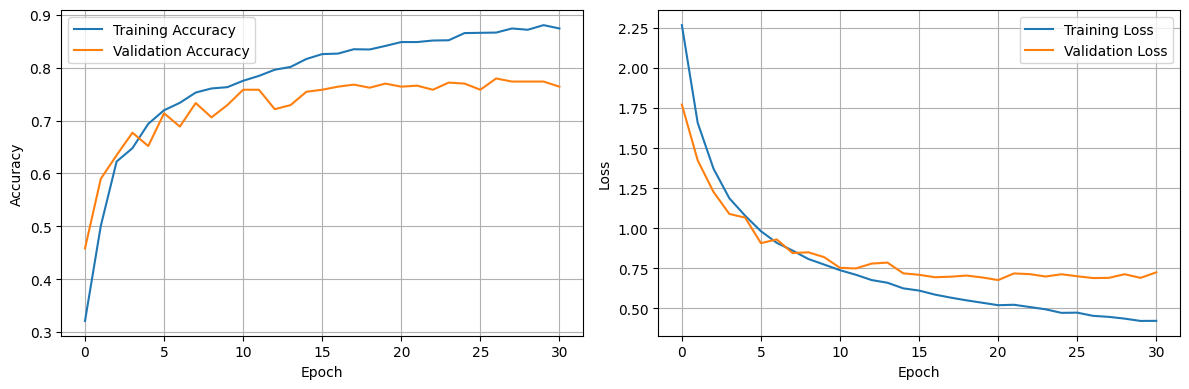

Model saved successfully.


In [137]:
import matplotlib.pyplot as plt

# Continuing from the previous part...

# Plotting the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Saving the trained model
#model.save('animal_sound_classification_model.h5')

print("Model saved successfully.")

#  (Next, we can work on loading the saved model and using it for predictions in a separate script or later in your current script)


17/17 [==============================] - 0s 3ms/step


2023-09-11 00:48:15.212217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


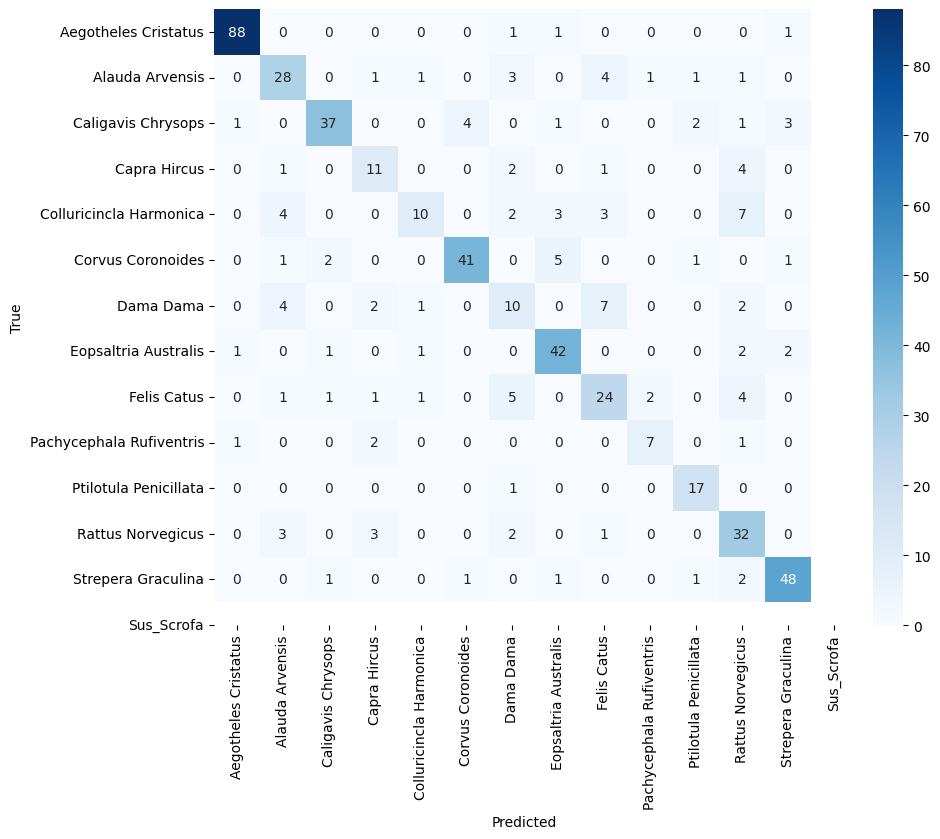

ValueError: Number of classes, 13, does not match size of target_names, 14. Try specifying the labels parameter

In [138]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# ... (After training your model)

# Predict the classes of the validation set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print a classification report
print(classification_report(y_test, y_pred_classes, target_names=class_names))


In [139]:
import pickle

# Save the class_names and LabelEncoder object after training your model
with open('class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)


## Test model on 2 sec chunk

In [144]:

import pickle
import librosa
import numpy as np
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

# Define the function to load a single audio file
def load_audio_file(file_path):
    wav, sr = librosa.load(file_path, sr=16000)
    return np.array([wav])

# Define the function to extract features
def extract_features(model, X):
    features = []
    for wav in X:
        scores, embeddings, spectrogram = model(wav)
        features.append(embeddings.numpy().mean(axis=0))
    return np.array(features)

# Load the class names and LabelEncoder object
with open('class_names.pkl', 'rb') as f:
    class_names = pickle.load(f)

with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Load the YAMNet model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# Load your trained model
#model = load_model('model76.h5')

# Load a single audio file and extract features
# Replace 'path/to/your/audiofile.wav' with the actual path to your audio file
X_new = load_audio_file('/Users/ankush/Downloads/deakin-units/data/cleaned3/Felis Catus/cat_30-0_chunk-0_segment-remaining.wav')  
X_new_features = extract_features(yamnet_model, X_new)

# Make predictions
predictions = model.predict(X_new_features)

# Get the top two probabilities and their respective class indices
top_two_prob_indices = np.argsort(predictions[0])[-2:]
top_two_prob_values = predictions[0][top_two_prob_indices]

# Convert class indices to class names
top_two_class_names = le.inverse_transform(top_two_prob_indices)

# Print the top two class names along with their probabilities
# Print the top two class names along with their probabilities
for i in range(2):
    print(f"Class: {class_names[top_two_prob_indices[1-i]]}, Probability: {top_two_prob_values[1-i]:.2f}")

2023-09-11 01:18:04.425587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step
Class: Felis Catus, Probability: 0.99
Class: Dama Dama, Probability: 0.00


In [ ]:

import pickle
import librosa
import numpy as np
import tensorflow_hub as hub
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

# Define the function to load a single audio file
def load_audio_file(file_path):
    wav, sr = librosa.load(file_path, sr=16000)
    return np.array([wav])

# Define the function to extract features
def extract_features(model, X):
    features = []
    for wav in X:
        scores, embeddings, spectrogram = model(wav)
        features.append(embeddings.numpy().mean(axis=0))
    return np.array(features)

# Load the class names and LabelEncoder object
with open('class_names.pkl', 'rb') as f:
    class_names = pickle.load(f)

with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Load the YAMNet model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

# Load your trained model
#model = load_model('model76.h5')

# Load a single audio file and extract features
# Replace 'path/to/your/audiofile.wav' with the actual path to your audio file
X_new = load_audio_file('/Users/ankush/Downloads/deakin-units/data/cleaned3/Felis Catus/cat_30-0_chunk-0_segment-remaining.wav')  
X_new_features = extract_features(yamnet_model, X_new)

# Make predictions
predictions = model.predict(X_new_features)

# Get the top two probabilities and their respective class indices
top_two_prob_indices = np.argsort(predictions[0])[-2:]
top_two_prob_values = predictions[0][top_two_prob_indices]

# Convert class indices to class names
top_two_class_names = le.inverse_transform(top_two_prob_indices)

# Print the top two class names along with their probabilities
# Print the top two class names along with their probabilities
for i in range(2):
    print(f"Class: {class_names[top_two_prob_indices[1-i]]}, Probability: {top_two_prob_values[1-i]:.2f}")